In [1]:
import os
import glob
import wandb
import torch
import random
import numpy as np
import pandas as pd
from rich import print
from pathlib import Path
from tqdm.auto import tqdm
from dotenv import load_dotenv
from collections import defaultdict
from huggingface_hub import login

In [2]:
from datasets import Dataset, DatasetDict

import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
sns.set_theme(context='notebook', style='dark')
tqdm.pandas()

In [4]:
# fix random seed
seed = 42

random.seed(seed)

np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

transformers.set_seed(seed)

In [5]:
# wandb configs
PROJECT_NAME = 'ARABIC_DISAMBIGUATION_STUDY'
JOB_TYPE = 'MODELING'
TAGS = ['MODELING', 'TRANSFORMERS', 'ARABERT', 'CLASSIFICATION', 'DISAMBIGUATION', 'TOPIC']
NOTES = 'Transformers modeling using AraBERT'
RUN_NAME = 'AraBERT_Topic_Classification_Modeling_Disambg'
config = defaultdict(dict)
config['Disambiguation'] = True

In [6]:
to_use_artifact_name = 'Topic-Classification-Dataset:latest'
model_ckpt = 'aubmindlab/bert-base-arabertv2'
data_ckpt = 'SANAD'
model_name = f'{model_ckpt.split("/")[-1]}-{data_ckpt}'
model_path = Path(f'../models/{model_name}')

In [7]:
print(model_path)

../models/bert-base-arabertv2-SANAD

In [8]:
load_dotenv()
wandb.login()
login(token=os.getenv('HF_TOKEN'),
      add_to_git_credential=True, write_permission=True)  # HF

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/hossam/.cache/huggingface/token
Login successful


In [9]:
run = wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE,
                 name=RUN_NAME, notes=NOTES, tags=TAGS, config=config)

In [10]:
data_artifact = run.use_artifact(to_use_artifact_name)
data_path = data_artifact.download(
    root=Path(f'../data/{to_use_artifact_name}'))
data_path = Path(data_path)

wandb: Downloading large artifact Topic-Classification-Dataset:latest, 83.38MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:3.4


In [11]:
datasets = DatasetDict({})
for f in glob.glob(f'{str(data_path)}/*'):
    datasets[f.split('/')[-1]] = Dataset.from_pandas(pd.read_csv(f),
                                                     preserve_index=False)

In [12]:
datasets

DatasetDict({
    test: Dataset({
        features: ['text', 'label', 'processed_text', 'processed_text_arabert'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['text', 'label', 'processed_text', 'processed_text_arabert'],
        num_rows: 8000
    })
    valid: Dataset({
        features: ['text', 'label', 'processed_text', 'processed_text_arabert'],
        num_rows: 1000
    })
})

In [13]:
label_names = datasets['train'].to_pandas().label.unique().tolist()
label_names

['Sports', 'Medical', 'Politics', 'Finance', 'Tech', 'Religion', 'Culture']

In [14]:
label2id = {l: i for i, l in enumerate(label_names)}
id2label = {i: l for i, l in enumerate(label_names)}

In [15]:
datasets = datasets.rename_column('label', 'labels')
datasets = datasets.map(
    lambda x: {'labels': label2id[x['labels']]}, batched=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
datasets = datasets.map(lambda x: tokenizer(x['processed_text_arabert'], truncation=True, max_length=128), batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [18]:
datasets

DatasetDict({
    test: Dataset({
        features: ['text', 'labels', 'processed_text', 'processed_text_arabert', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['text', 'labels', 'processed_text', 'processed_text_arabert', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    valid: Dataset({
        features: ['text', 'labels', 'processed_text', 'processed_text_arabert', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(label_names), label2id=label2id, id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
device = torch.device('cuda')
device

device(type='cuda')

In [21]:
weights = datasets['train'].to_pandas(
).labels.value_counts(normalize=True).to_dict()
weights

{3: 0.2775,
 0: 0.2085,
 2: 0.1445,
 1: 0.13725,
 4: 0.131875,
 5: 0.05275,
 6: 0.047625}

In [22]:
w = torch.tensor([0.0] * len(label_names), device=device, dtype=torch.float32)
w

tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [23]:
for i, k in weights.items():
    w[i] = k

w

tensor([0.2085, 0.1373, 0.1445, 0.2775, 0.1319, 0.0527, 0.0476],
       device='cuda:0')

In [24]:
w = 1 / w
w = w / w.sum()
w

tensor([0.0684, 0.1039, 0.0987, 0.0514, 0.1081, 0.2703, 0.2993],
       device='cuda:0')

In [25]:
loss_fn = torch.nn.CrossEntropyLoss(weight=w)

In [26]:
num_epochs = 3
batch_size = 16
total_steps = len(datasets['train']) * num_epochs // batch_size
total_steps

1500

In [27]:
training_args = TrainingArguments(
    output_dir=model_path,
    run_name=RUN_NAME,
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=64,
    num_train_epochs=num_epochs,
    weight_decay=1e-5,
    warmup_ratio=0.05,
    # eval_steps=250,
    eval_strategy='epoch',
    save_strategy='epoch',
    # save_safetensors=False,
    log_level='error',
    seed=seed,
    load_best_model_at_end=True,
    # metric_for_best_model='F1',
)

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
class WeightedCETrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')  # [batch_size, num_labels]
        outputs = model(**inputs)
        logits = outputs.get('logits')  # [batch_size, num_labels]
        loss = loss_fn(
            logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [30]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    prec = precision_score(labels, pred, average='macro')
    rec = recall_score(labels, pred, average='macro')
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}

In [31]:
trainer = WeightedCETrainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['valid'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.501200,0.124101,0.966000,0.963055,0.971264,0.966843
2,0.121700,0.105372,0.969000,0.964652,0.973588,0.969004
3,0.064100,0.107596,0.974000,0.973030,0.977255,0.975099


TrainOutput(global_step=1500, training_loss=0.2289968287150065, metrics={'train_runtime': 668.6495, 'train_samples_per_second': 35.893, 'train_steps_per_second': 2.243, 'total_flos': 1578737203200000.0, 'train_loss': 0.2289968287150065, 'epoch': 3.0})

In [33]:
test_outs = trainer.predict(datasets['test'])
test_preds = np.argmax(test_outs[0], axis=-1)
test_labels = test_outs[1]

In [34]:
print(classification_report(test_labels, test_preds,
      target_names=label_names, digits=4))

precision    recall  f1-score   support

      Sports     0.9905    1.0000    0.9952       208
     Medical     0.9638    0.9708    0.9673       137
    Politics     0.9437    0.9241    0.9338       145
     Finance     0.9610    0.9783    0.9696       277
        Tech     0.9695    0.9621    0.9658       132
    Religion     0.9636    1.0000    0.9815        53
     Culture     0.9762    0.8542    0.9111        48

    accuracy                         0.9670      1000
   macro avg     0.9669    0.9557    0.9606      1000
weighted avg     0.9670    0.9670    0.9667      1000

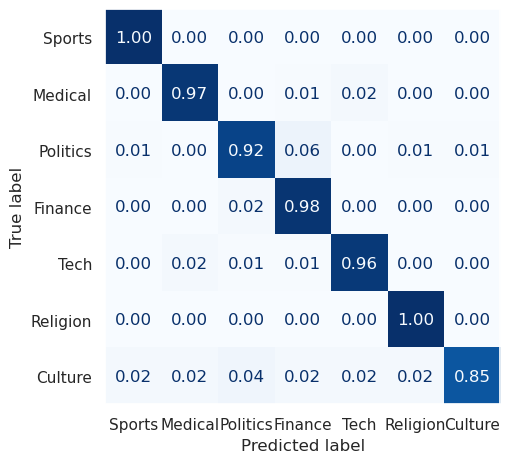

In [35]:
cm = confusion_matrix(test_labels, test_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots()
ax.grid(False)
disp.plot(cmap='Blues', colorbar=False, ax=ax, values_format='.2f')
plt.tight_layout()
plt.show()

In [36]:
summary = {}
scores = compute_scores(test_outs[:2])
summary['test_f1'] = scores['F1']
summary['test_precision'] = scores['Precision']
summary['test_recall'] = scores['Recall']
summary

{'test_f1': 0.9606066512774685,
 'test_precision': 0.966884524961775,
 'test_recall': 0.9556525828158424}

In [37]:
for k, v in summary.items():
    run.summary[k] = v

In [38]:
run.log({'Topic Classification Test Confusion Matrix': wandb.plot.confusion_matrix(
    y_true=test_labels, preds=test_preds, class_names=label_names)})

In [39]:
trainer.save_model(model_path)

In [40]:
wandb.finish()

eval/Accuracy,▁▄█
eval/F1,▁▃█
eval/Precision,▁▂█
eval/Recall,▁▄█
eval/loss,█▁▂
eval/runtime,▆█▁
eval/samples_per_second,▃▁█
eval/steps_per_second,▃▁█
test/Accuracy,▁
test/F1,▁
test/Precision,▁
